In [67]:
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from string import punctuation
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict
from sklearn import metrics
from time import time
from plotmat import plot_mat
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import homogeneity_score, v_measure_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import NMF
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import numpy as np
from plotmat import plot_mat # using the provided plotmat.py from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

In [2]:

stop_words_skt = text.ENGLISH_STOP_WORDS

#nltk.download('stopwords' )
stop_words_en = stopwords.words('english')

print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
print("# of stop_words_en:\t\t %s" % len(stop_words_en))

print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
print("# of combined_stopwords:\t %s" % len(combined_stopwords))

# of stop_words_skt:		 318
# of stop_words_en:		 179
# of punctuation:		 32
# of combined_stopwords:	 410


In [3]:
class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
categories = class1+class2
contain_class1 = set(class1)
contain_class2 = set(class2)

In [4]:
data_train = fetch_20newsgroups(subset="all",categories=categories,
    random_state=42,
    remove=("headers", "footers"))

In [5]:
df_data = pd.DataFrame({"content":data_train.data,"label":data_train.target})

In [6]:
df_data

,content,label
0,"thought I'd post this as well as e-mail it, ju...",2
1,I have been experiencing several end-user prob...,1
2,In article <pdb059-210493145738@kilimanjaro.jp...,2
3,Could someone please do one of the following:\...,3
4,Your list of Jewish ballplayers includes Levi ...,6
...,...,...
7877,In a recent article rcaldrn@med.miami.edu (Ric...,1
7878,In article <1993Apr20.004746.13007@ramsey.cs.l...,6
7879,Rithea Hong (r0h7630@tamuts.tamu.edu) wrote:\n...,2
7880,In article <1r9bi6$s2b@apple.com> opstad@apple...,3


In [7]:
lab1 = 0
lab2 = 0
for x in df_data["label"]:
    if x <=3:
        lab1+=1
    else:
        lab2+=1
print(lab1,lab2)

3903 3979


In [8]:
vectorizer = CountVectorizer(min_df=3,stop_words = 'english')
pipe = Pipeline([('count', vectorizer),('tfid', TfidfTransformer())])

In [9]:
data_transformed = pipe.fit_transform(df_data["content"])

# Q1

In [10]:
data_transformed.shape

(7882, 23522)

# Q2

In [11]:
labels = [ 1 if x <=3 else 2 for x in df_data['label']]
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [12]:
kmeans = KMeans(
        n_clusters=2,
        max_iter=1100,
        n_init=40,
        random_state=0,
)
kmeans.fit(data_transformed)

KMeans(max_iter=1100, n_clusters=2, n_init=40, random_state=0)

In [13]:
kmeans.labels_

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [14]:
contingency_matrix(labels,kmeans.labels_)

array([[3155,  748],
       [  53, 3926]])

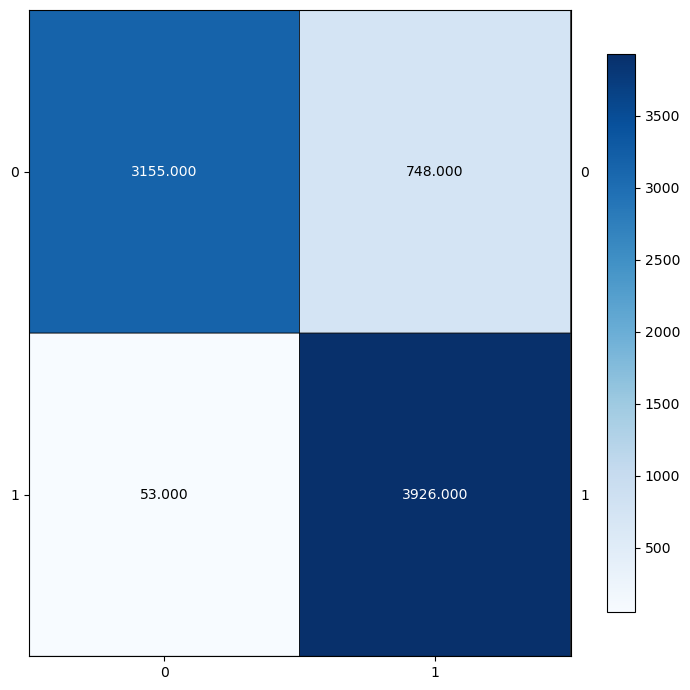

In [15]:
plot_mat(contingency_matrix(labels,kmeans.labels_),size=(7,7))

# Q3

In [16]:
fit_and_evaluate(kmeans, data_transformed, name="KMeans\non tf-idf vectors")

clustering done in 1.71 ± 0.07 s 
Homogeneity: 0.579 ± 0.011
Completeness: 0.592 ± 0.010
V-measure: 0.585 ± 0.010
Adjusted Rand-Index: 0.641 ± 0.014
Silhouette Coefficient: 0.004 ± 0.000


In [17]:
print("Homogeneity: ", homogeneity_score(labels,kmeans.labels_))
print("Completeness: ",completeness_score(labels,kmeans.labels_))
print("V-measure: ",v_measure_score(labels,kmeans.labels_))
print("Adjusted Rand Index: ",adjusted_rand_score(labels,kmeans.labels_))
print("Adjusted mutual information score: ",adjusted_mutual_info_score(labels,kmeans.labels_))

Homogeneity:  0.5879597302137981
Completeness:  0.6017672613341238
V-measure:  0.5947833732261021
Adjusted Rand Index:  0.6498185713778436
Adjusted mutual information score:  0.5947458446368514


# Q4

In [18]:
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(data_transformed)


TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler


model = TruncatedSVD(n_components=1000, algorithm = 'randomized', n_iter=7, random_state=42)
model.fit_transform(data_transformed)

array([[ 0.13202992,  0.0013572 , -0.01187849, ...,  0.01784048,
        -0.00238382,  0.0137484 ],
       [ 0.13071614, -0.05379625, -0.05736558, ...,  0.01241411,
        -0.01490916, -0.01633566],
       [ 0.1574049 , -0.12033844,  0.1196939 , ...,  0.00650918,
         0.00837011,  0.00774894],
       ...,
       [ 0.07522627,  0.01059875, -0.01102102, ...,  0.01133393,
         0.00294935,  0.0396763 ],
       [ 0.15158911,  0.01446036, -0.00536385, ..., -0.01087907,
        -0.00105909,  0.0064974 ],
       [ 0.06821521,  0.01989866,  0.01911755, ..., -0.03359514,
         0.00826496,  0.01870149]])

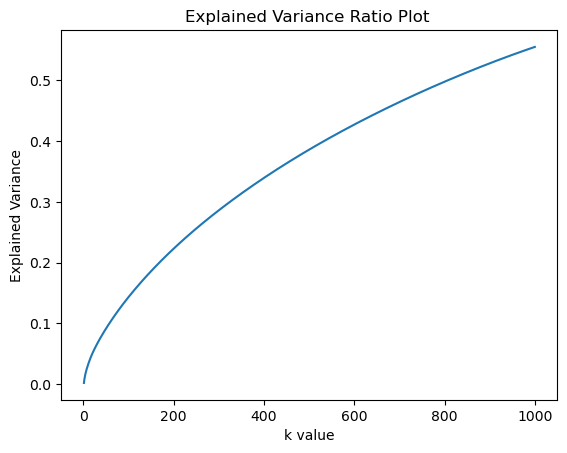

In [20]:
explained = np.cumsum(model.explained_variance_ratio_)
plt.plot(range(1,1001), explained)
plt.title("Explained Variance Ratio Plot ")
plt.xlabel('k value')
plt.ylabel('Explained Variance')
plt.show()

# Q5

In [21]:
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
lab_collections = []
for x in tqdm(range(len(r))):
    model = TruncatedSVD(n_components=r[x], algorithm = 'randomized', n_iter=7, random_state=42)
    matri = model.fit_transform(data_transformed)
    kmeans.fit(matri)
    lab_collections.append(kmeans.labels_)



100%|███████████████████████████████████████████| 14/14 [00:21<00:00,  1.55s/it]


In [22]:
hom = []
com = []
v_mea = []
adj_r = []
adj_mu = []
for x in range(len(r)):
    hom.append(homogeneity_score(labels,lab_collections[x]))
    com.append(completeness_score(labels,lab_collections[x]))
    v_mea.append(v_measure_score(labels,lab_collections[x]))
    adj_r.append(adjusted_rand_score(labels,lab_collections[x]))
    adj_mu.append(adjusted_mutual_info_score(labels,lab_collections[x]))
    print("Homogeneity: ", homogeneity_score(labels,lab_collections[x]))
    print("Completeness: ",completeness_score(labels,lab_collections[x]))
    print("V-measure: ",v_measure_score(labels,lab_collections[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(labels,lab_collections[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(labels,lab_collections[x]))
    print("")

Homogeneity:  0.019188293613963906
Completeness:  0.0194830744416157
V-measure:  0.0193345605126322
Adjusted Rand Index:  0.026249391352172042
Adjusted mutual information score:  0.019244095394142905

Homogeneity:  0.5290568591667052
Completeness:  0.5466431001230201
V-measure:  0.5377062240054288
Adjusted Rand Index:  0.585225410661106
Adjusted mutual information score:  0.5376632083842698

Homogeneity:  0.5380804237449429
Completeness:  0.5545598843301893
V-measure:  0.5461958804686826
Adjusted Rand Index:  0.5969320910136512
Adjusted mutual information score:  0.546153707454081

Homogeneity:  0.5024767689891753
Completeness:  0.5278865768783753
V-measure:  0.51486835708284
Adjusted Rand Index:  0.5369512180516358
Adjusted mutual information score:  0.5148228469326567

Homogeneity:  0.5164430333890327
Completeness:  0.5392857923795873
V-measure:  0.5276172889896297
Adjusted Rand Index:  0.5572234261261124
Adjusted mutual information score:  0.5275731057111873

Homogeneity:  0.5248995

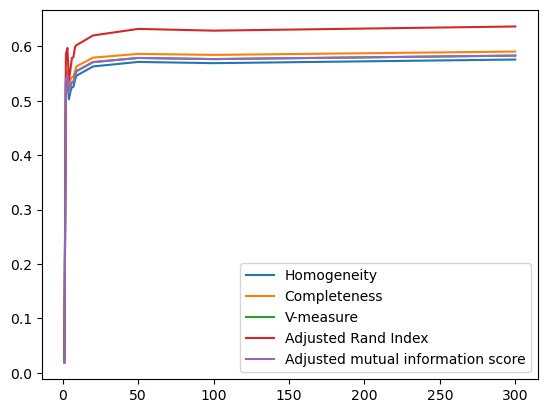

In [23]:
plt.plot(r, hom, label = "Homogeneity")
plt.plot(r, com, label = "Completeness")
plt.plot(r, v_mea, label = "V-measure")
plt.plot(r, adj_r, label = "Adjusted Rand Index")
plt.plot(r, adj_mu, label = "Adjusted mutual information score")
plt.legend()
plt.show()

In [24]:
lab_collections2 = []
for x in tqdm(range(len(r))):
    NMF_1 = NMF(n_components=r[x], init='random', random_state=42,max_iter=1000)
    W = NMF_1.fit_transform(data_transformed)
    kmeans.fit(W)
    lab_collections2.append(kmeans.labels_)



100%|███████████████████████████████████████████| 14/14 [14:56<00:00, 64.01s/it]


In [25]:
hom2 = []
com2 = []
v_mea2 = []
adj_r2 = []
adj_mu2 = []
for x in range(len(r)):
    hom2.append(homogeneity_score(labels,lab_collections2[x]))
    com2.append(completeness_score(labels,lab_collections2[x]))
    v_mea2.append(v_measure_score(labels,lab_collections2[x]))
    adj_r2.append(adjusted_rand_score(labels,lab_collections2[x]))
    adj_mu2.append(adjusted_mutual_info_score(labels,lab_collections2[x]))
    print("Homogeneity: ", homogeneity_score(labels,lab_collections2[x]))
    print("Completeness: ",completeness_score(labels,lab_collections2[x]))
    print("V-measure: ",v_measure_score(labels,lab_collections2[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(labels,lab_collections2[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(labels,lab_collections2[x]))
    print("")

Homogeneity:  0.019188293613963906
Completeness:  0.0194830744416157
V-measure:  0.0193345605126322
Adjusted Rand Index:  0.026249391352172042
Adjusted mutual information score:  0.019244095394142905

Homogeneity:  0.49436629542018734
Completeness:  0.5201076638663424
V-measure:  0.5069103975543827
Adjusted Rand Index:  0.5287998174841438
Adjusted mutual information score:  0.5068641086497574

Homogeneity:  0.19968718430097612
Completeness:  0.29490362446142143
V-measure:  0.23813007991882781
Adjusted Rand Index:  0.11968934446218622
Adjusted mutual information score:  0.23804688632601634

Homogeneity:  0.04692504995474571
Completeness:  0.16542651155887647
V-measure:  0.07311128077804721
Adjusted Rand Index:  0.011097673265433138
Adjusted mutual information score:  0.0729789174470931

Homogeneity:  0.040791321221174695
Completeness:  0.1539550035833579
V-measure:  0.06449444436067417
Adjusted Rand Index:  0.00915047637987103
Adjusted mutual information score:  0.06435885802704695

Hom

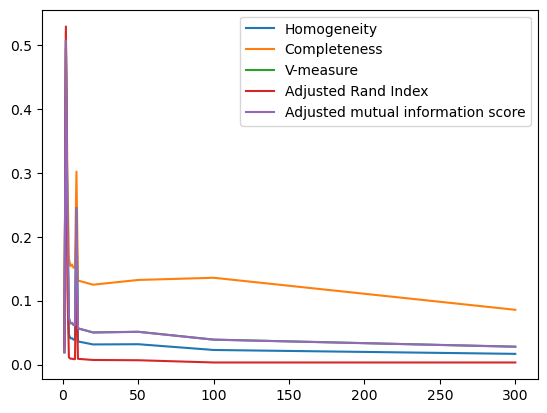

In [26]:
plt.plot(r, hom2, label = "Homogeneity")
plt.plot(r, com2, label = "Completeness")
plt.plot(r, v_mea2, label = "V-measure")
plt.plot(r, adj_r2, label = "Adjusted Rand Index")
plt.plot(r, adj_mu2, label = "Adjusted mutual information score")
plt.legend()
plt.show()

# Q8

In [27]:
best_pac = TruncatedSVD(n_components=300, algorithm = 'randomized', n_iter=7, random_state=42)
best_NMF = NMF(n_components=2, init='random', random_state=42,max_iter=1000)

In [28]:
best_pac_matrix = best_pac.fit_transform(data_transformed)
best_NMF_matrix = best_NMF.fit_transform(data_transformed)

In [29]:
kmeans = KMeans(
        n_clusters=2,
        max_iter=1100,
        n_init=40,
        random_state=0,
)

kmeans2 = KMeans(
        n_clusters=2,
        max_iter=1100,
        n_init=40,
        random_state=0,
)

kmeans.fit(best_pac_matrix)
kmeans2.fit(best_pac_matrix)

KMeans(max_iter=1100, n_clusters=2, n_init=40, random_state=0)

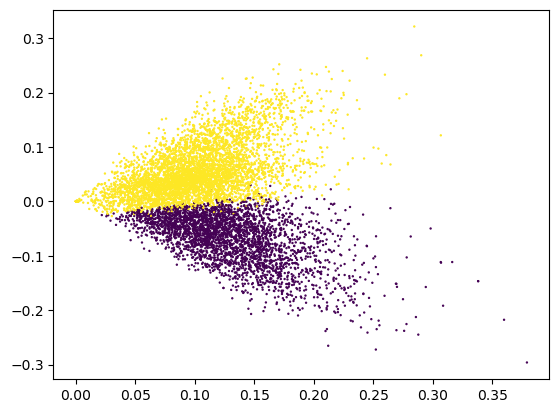

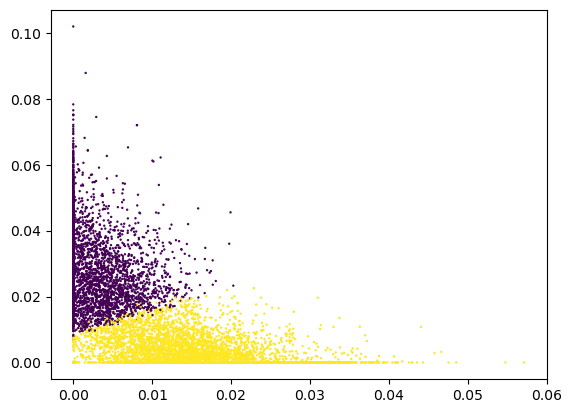

In [30]:
plt.scatter(best_pac_matrix[:,0] , best_pac_matrix[:,1] ,c = kmeans.labels_,s=0.5)
plt.show()
plt.scatter(best_NMF_matrix[:,0] , best_NMF_matrix[:,1] ,c = kmeans2.labels_,s=0.5)
plt.show()

In [31]:
labelss = []
for x in df_data["label"]:
    if x <=3:
        labelss.append(1)
    else:
        labelss.append(2)
print(lab1,lab2)

3903 3979


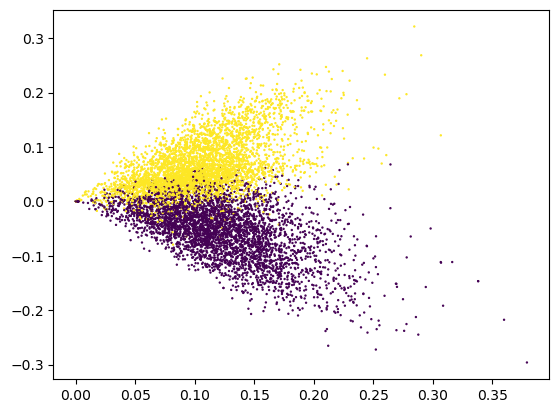

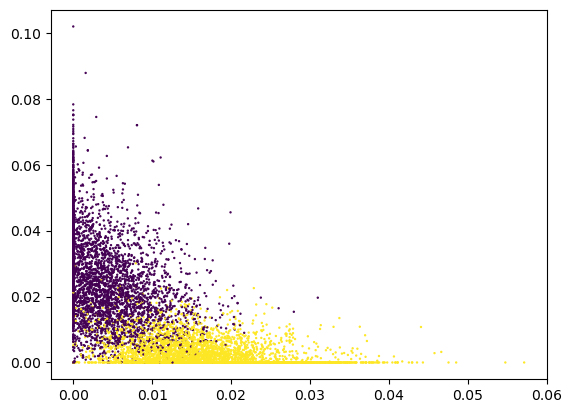

In [32]:
plt.scatter(best_pac_matrix[:,0] , best_pac_matrix[:,1] ,c = labelss,s=0.5)
plt.show()
plt.scatter(best_NMF_matrix[:,0] , best_NMF_matrix[:,1] ,c = labelss,s=0.5)
plt.show()

# Q10

In [55]:
data_train_20 = fetch_20newsgroups(subset="all",
    random_state=42,
    remove=("headers", "footers"))

In [56]:
df_data_20 = pd.DataFrame({"content":data_train_20.data,"label":data_train_20.target})

In [57]:
df_data_20

,content,label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,"|>The student of ""regional killings"" alias Dav...",17
3,In article <1993Apr19.034517.12820@julian.uwo....,3
4,1) I have an old Jasmine drive which I cann...,4
...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13
18842,In article <1993Apr22.004728.6736@mtu.edu> cmw...,12
18843,I just installed a DX2-66 CPU in a clone mothe...,3
18844,In article <1qkgbuINNs9n@shelley.u.washington....,1


In [58]:
data_transformed_20 = pipe.fit_transform(df_data_20["content"])

In [59]:
data_transformed_20.shape

(18846, 45365)

In [60]:
label_20 = np.array(data_train.target)
print(np.unique(label_20))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [81]:
kmeans = KMeans(
        n_clusters=20,
        max_iter=1100,
        n_init=40,
        random_state=0,
)

In [113]:
r = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
lab_collections_20 = []
for x in tqdm(range(len(r))):
    model = TruncatedSVD(n_components=r[x], algorithm = 'randomized', n_iter=7, random_state=42)
    matri = model.fit_transform(data_transformed_20)
    kmeans.fit(matri)
    lab_collections_20.append(kmeans.labels_)

100%|███████████████████████████████████████████| 14/14 [02:13<00:00,  9.56s/it]


In [125]:
hom_3 = []
com_3 = []
v_mea_3 = []
adj_r_3 = []
adj_mu_3 = []
for x in range(len(r)):
    hom_3.append(homogeneity_score(data_train_20.target,lab_collections_20[x]))
    com_3.append(completeness_score(data_train_20.target,lab_collections_20[x]))
    v_mea_3.append(v_measure_score(data_train_20.target,lab_collections_20[x]))
    adj_r_3.append(adjusted_rand_score(data_train_20.target,lab_collections_20[x]))
    adj_mu_3.append(adjusted_mutual_info_score(data_train_20.target,lab_collections_20[x]))
    print("Homogeneity: ", homogeneity_score(data_train_20.target,lab_collections_20[x]))
    print("Completeness: ",completeness_score(data_train_20.target,lab_collections_20[x]))
    print("V-measure: ",v_measure_score(data_train_20.target,lab_collections_20[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(data_train_20.target,lab_collections_20[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train_20.target,lab_collections_20[x]))
    print("Average: ",(homogeneity_score(data_train_20.target,lab_collections_20[x])+
         completeness_score(data_train_20.target,lab_collections_20[x])+
         v_measure_score(data_train_20.target,lab_collections_20[x])+
         adjusted_rand_score(data_train_20.target,lab_collections_20[x])+
          adjusted_mutual_info_score(data_train_20.target,lab_collections_20[x]))/5
         )
    print("")

Homogeneity:  0.02414477211123332
Completeness:  0.026109012106166563
V-measure:  0.02508850456418185
Adjusted Rand Index:  0.005069466603507795
Adjusted mutual information score:  0.02177877822712708
Average:  0.02043810672244332

Homogeneity:  0.21197971757905085
Completeness:  0.2243664034397606
V-measure:  0.21799724825942668
Adjusted Rand Index:  0.06560917910832997
Adjusted mutual information score:  0.21539480681584305
Average:  0.18706947104048224

Homogeneity:  0.24653454174561812
Completeness:  0.26465748681340473
V-measure:  0.25527476402561383
Adjusted Rand Index:  0.08421690046373036
Adjusted mutual information score:  0.25277023655540415
Average:  0.22069078592075422

Homogeneity:  0.31301053083385316
Completeness:  0.33632152509638974
V-measure:  0.3242475960945976
Adjusted Rand Index:  0.11824377412319044
Adjusted mutual information score:  0.3219814388561431
Average:  0.2827609730008348

Homogeneity:  0.32313809864466086
Completeness:  0.35118683066780604
V-measure:  0

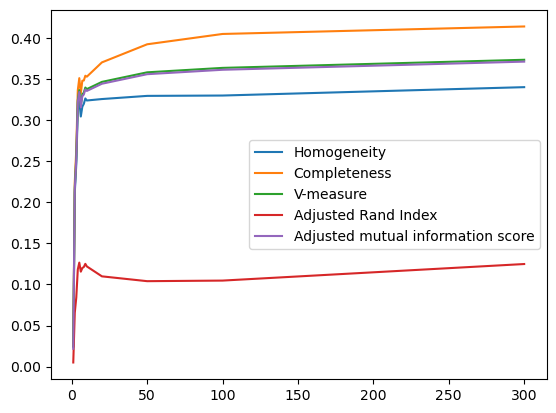

In [115]:
plt.plot(r, hom_3, label = "Homogeneity")
plt.plot(r, com_3, label = "Completeness")
plt.plot(r, v_mea_3, label = "V-measure")
plt.plot(r, adj_r_3, label = "Adjusted Rand Index")
plt.plot(r, adj_mu_3, label = "Adjusted mutual information score")
plt.legend()
plt.show()

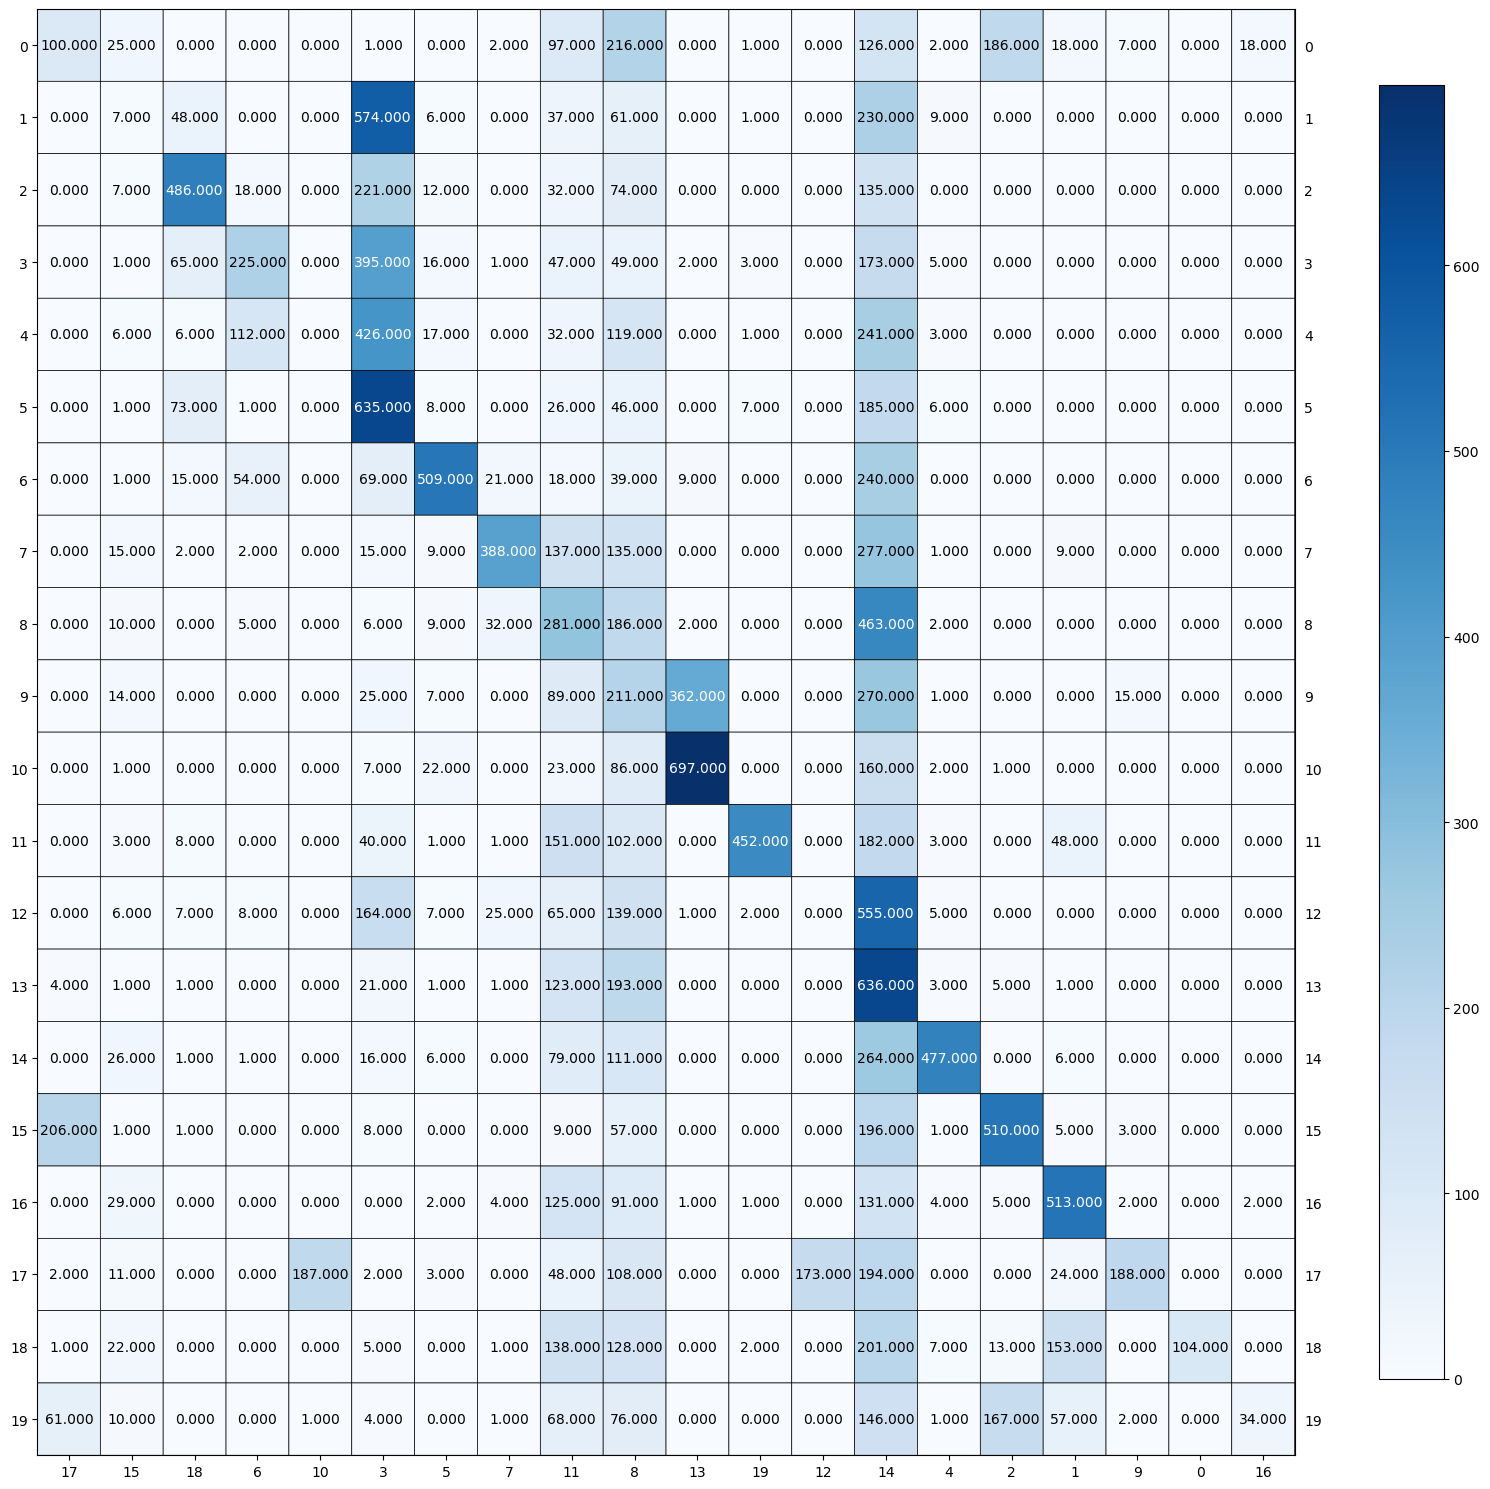

In [116]:
cm = confusion_matrix(data_train_20.target, lab_collections_20[-1])
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [120]:
lab_collections2_20 = []
for x in tqdm(range(len(r))):
    NMF_1 = NMF(n_components=r[x], init='random', random_state=42,max_iter=1000)
    W = NMF_1.fit_transform(data_transformed_20)
    kmeans.fit(W)
    lab_collections2_20.append(kmeans.labels_)

 64%|████████████████████████████▎               | 9/14 [00:47<00:31,  6.29s/it]/Users/felix/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████████████████████████████████████| 14/14 [51:42<00:00, 221.59s/it]


In [123]:
hom_4 = []
com_4 = []
v_mea_4 = []
adj_r_4 = []
adj_mu_4 = []
for x in range(len(r)):
    hom_4.append(homogeneity_score(data_train_20.target,lab_collections2_20[x]))
    com_4.append(completeness_score(data_train_20.target,lab_collections2_20[x]))
    v_mea_4.append(v_measure_score(data_train_20.target,lab_collections2_20[x]))
    adj_r_4.append(adjusted_rand_score(data_train_20.target,lab_collections2_20[x]))
    adj_mu_4.append(adjusted_mutual_info_score(data_train_20.target,lab_collections2_20[x]))
    print("Homogeneity: ", homogeneity_score(data_train_20.target,lab_collections2_20[x]))
    print("Completeness: ",completeness_score(data_train_20.target,lab_collections2_20[x]))
    print("V-measure: ",v_measure_score(data_train_20.target,lab_collections2_20[x]))
    print("Adjusted Rand Index: ",adjusted_rand_score(data_train_20.target,lab_collections2_20[x]))
    print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train_20.target,lab_collections2_20[x]))
    print("Average: ",(homogeneity_score(data_train_20.target,lab_collections2_20[x])+
         completeness_score(data_train_20.target,lab_collections2_20[x])+
         v_measure_score(data_train_20.target,lab_collections2_20[x])+
         adjusted_rand_score(data_train_20.target,lab_collections2_20[x])+
          adjusted_mutual_info_score(data_train_20.target,lab_collections2_20[x]))/5
         )
    print("")

Homogeneity:  0.02414477211123332
Completeness:  0.026109012106166563
V-measure:  0.02508850456418185
Adjusted Rand Index:  0.005069466603507795
Adjusted mutual information score:  0.02177877822712708
Average:  0.02043810672244332

Homogeneity:  0.1912056689667014
Completeness:  0.20432644325820276
V-measure:  0.1975484319136985
Adjusted Rand Index:  0.05764558714976883
Adjusted mutual information score:  0.19485515419845262
Average:  0.16911625709736483

Homogeneity:  0.2186383223258225
Completeness:  0.2366967277284554
V-measure:  0.22730943047056248
Adjusted Rand Index:  0.06473139112283063
Adjusted mutual information score:  0.22470451667153774
Average:  0.19441607766384178

Homogeneity:  0.24691668549473988
Completeness:  0.2944008776362139
V-measure:  0.26857613299013133
Adjusted Rand Index:  0.07621829634185957
Adjusted mutual information score:  0.26595626537107325
Average:  0.2304136515668036

Homogeneity:  0.297368780469481
Completeness:  0.3325269314588892
V-measure:  0.3139

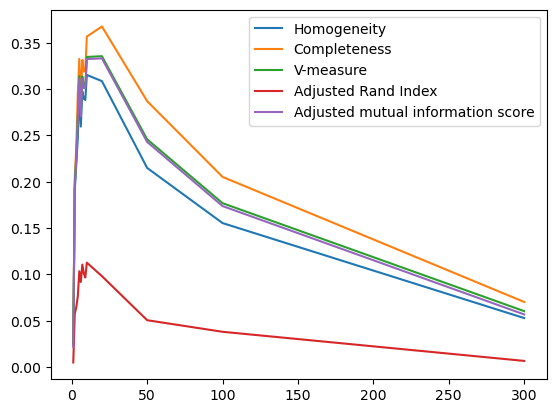

In [122]:
plt.plot(r, hom_4, label = "Homogeneity")
plt.plot(r, com_4, label = "Completeness")
plt.plot(r, v_mea_4, label = "V-measure")
plt.plot(r, adj_r_4, label = "Adjusted Rand Index")
plt.plot(r, adj_mu_4, label = "Adjusted mutual information score")
plt.legend()
plt.show()

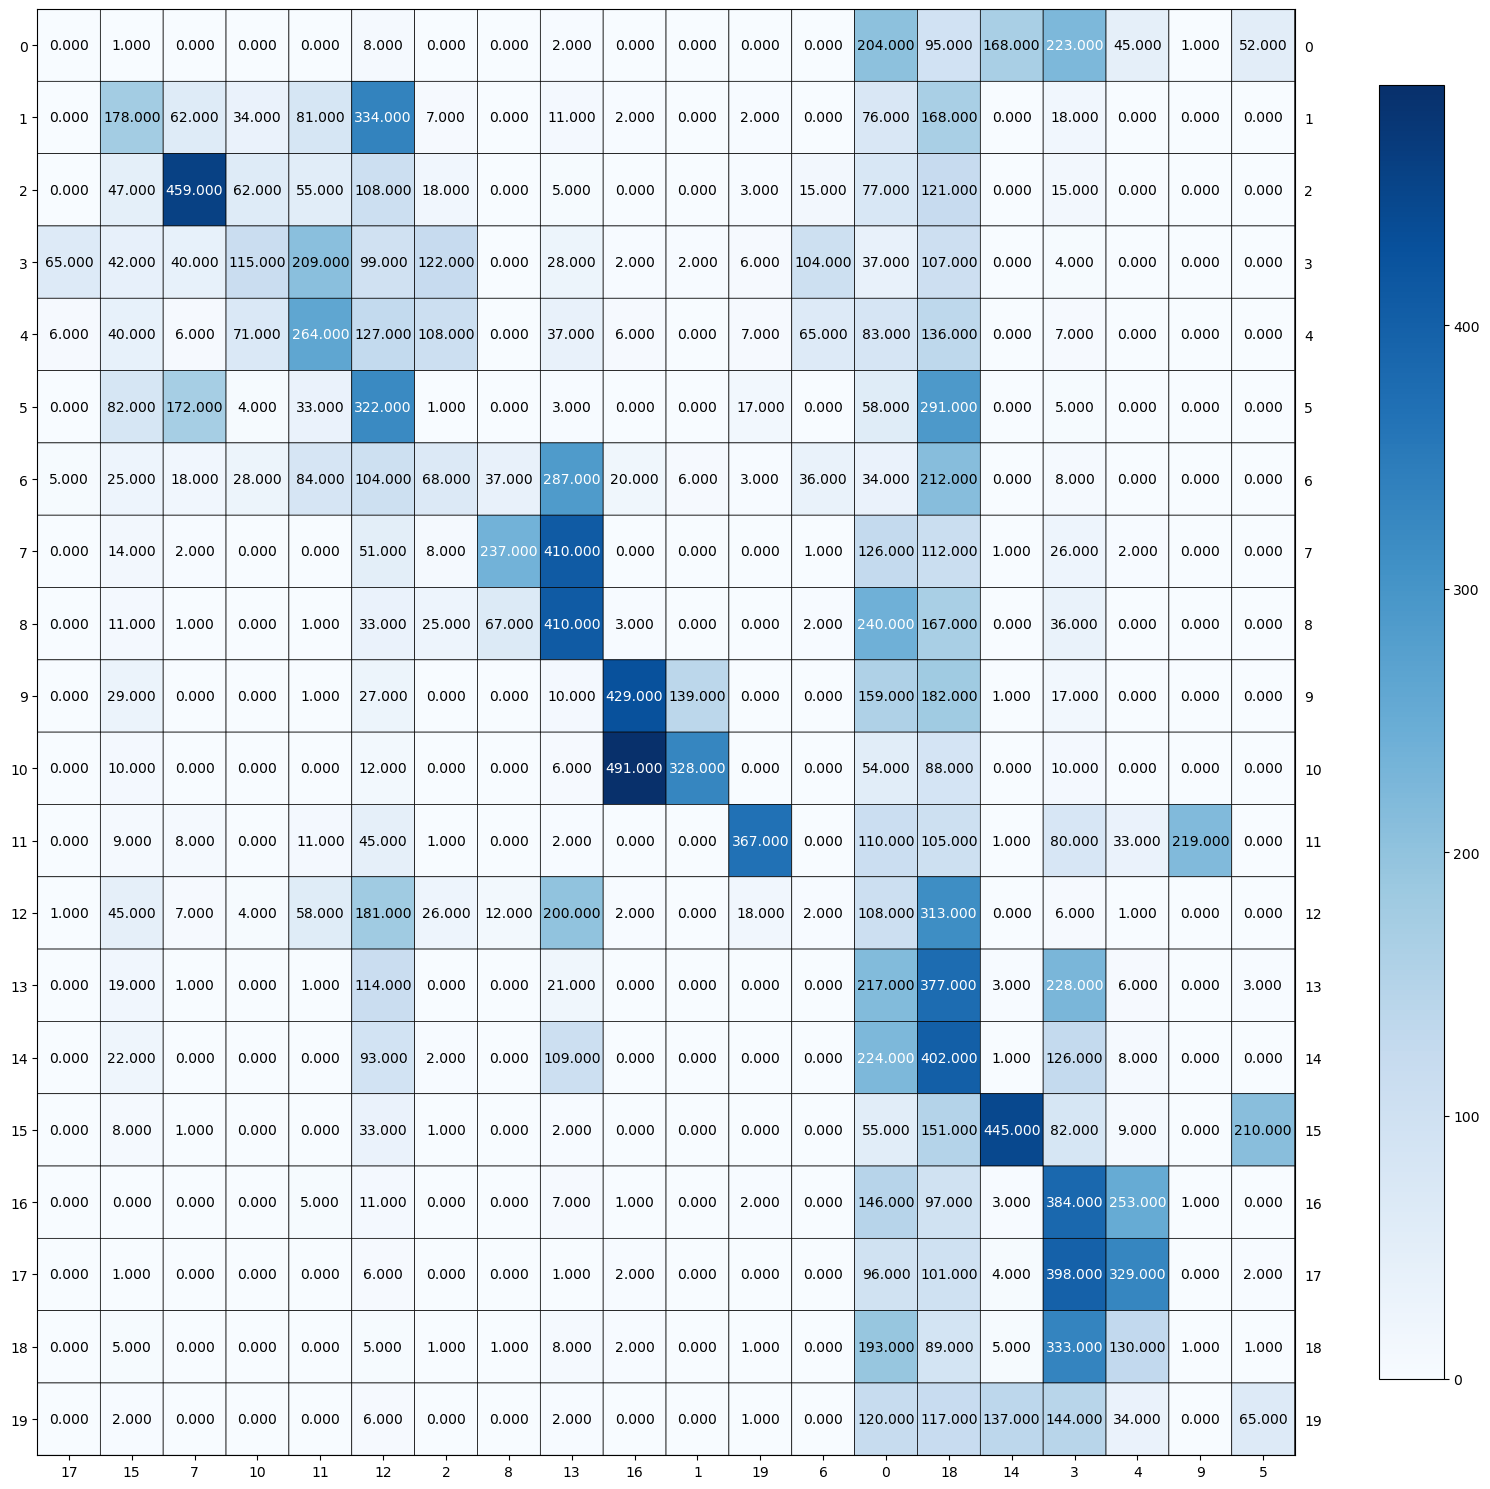

In [124]:
cm = confusion_matrix(data_train_20.target, lab_collections2_20[9])
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))

In [127]:
kmeans.fit(data_transformed_20)

KMeans(max_iter=1100, n_clusters=20, n_init=40, random_state=0)

In [128]:
print("Homogeneity: ", homogeneity_score(data_train.target,kmeans.labels_))
print("Completeness: ",completeness_score(data_train.target,kmeans.labels_))
print("V-measure: ",v_measure_score(data_train.target,kmeans.labels_))
print("Adjusted Rand Index: ",adjusted_rand_score(data_train.target,kmeans.labels_))
print("Adjusted mutual information score: ",adjusted_mutual_info_score(data_train.target,kmeans.labels_))
print("Average: ",(homogeneity_score(data_train.target,kmeans.labels_)+
     completeness_score(data_train.target,kmeans.labels_)+
     v_measure_score(data_train.target,kmeans.labels_)+
     adjusted_rand_score(data_train.target,kmeans.labels_)+
      adjusted_mutual_info_score(data_train.target,kmeans.labels_))/5
     )
print("")

Homogeneity:  0.34790859768457
Completeness:  0.39677714833899
V-measure:  0.37073942131701093
Adjusted Rand Index:  0.12210793219608113
Adjusted mutual information score:  0.368564014634305
Average:  0.32121942283419147



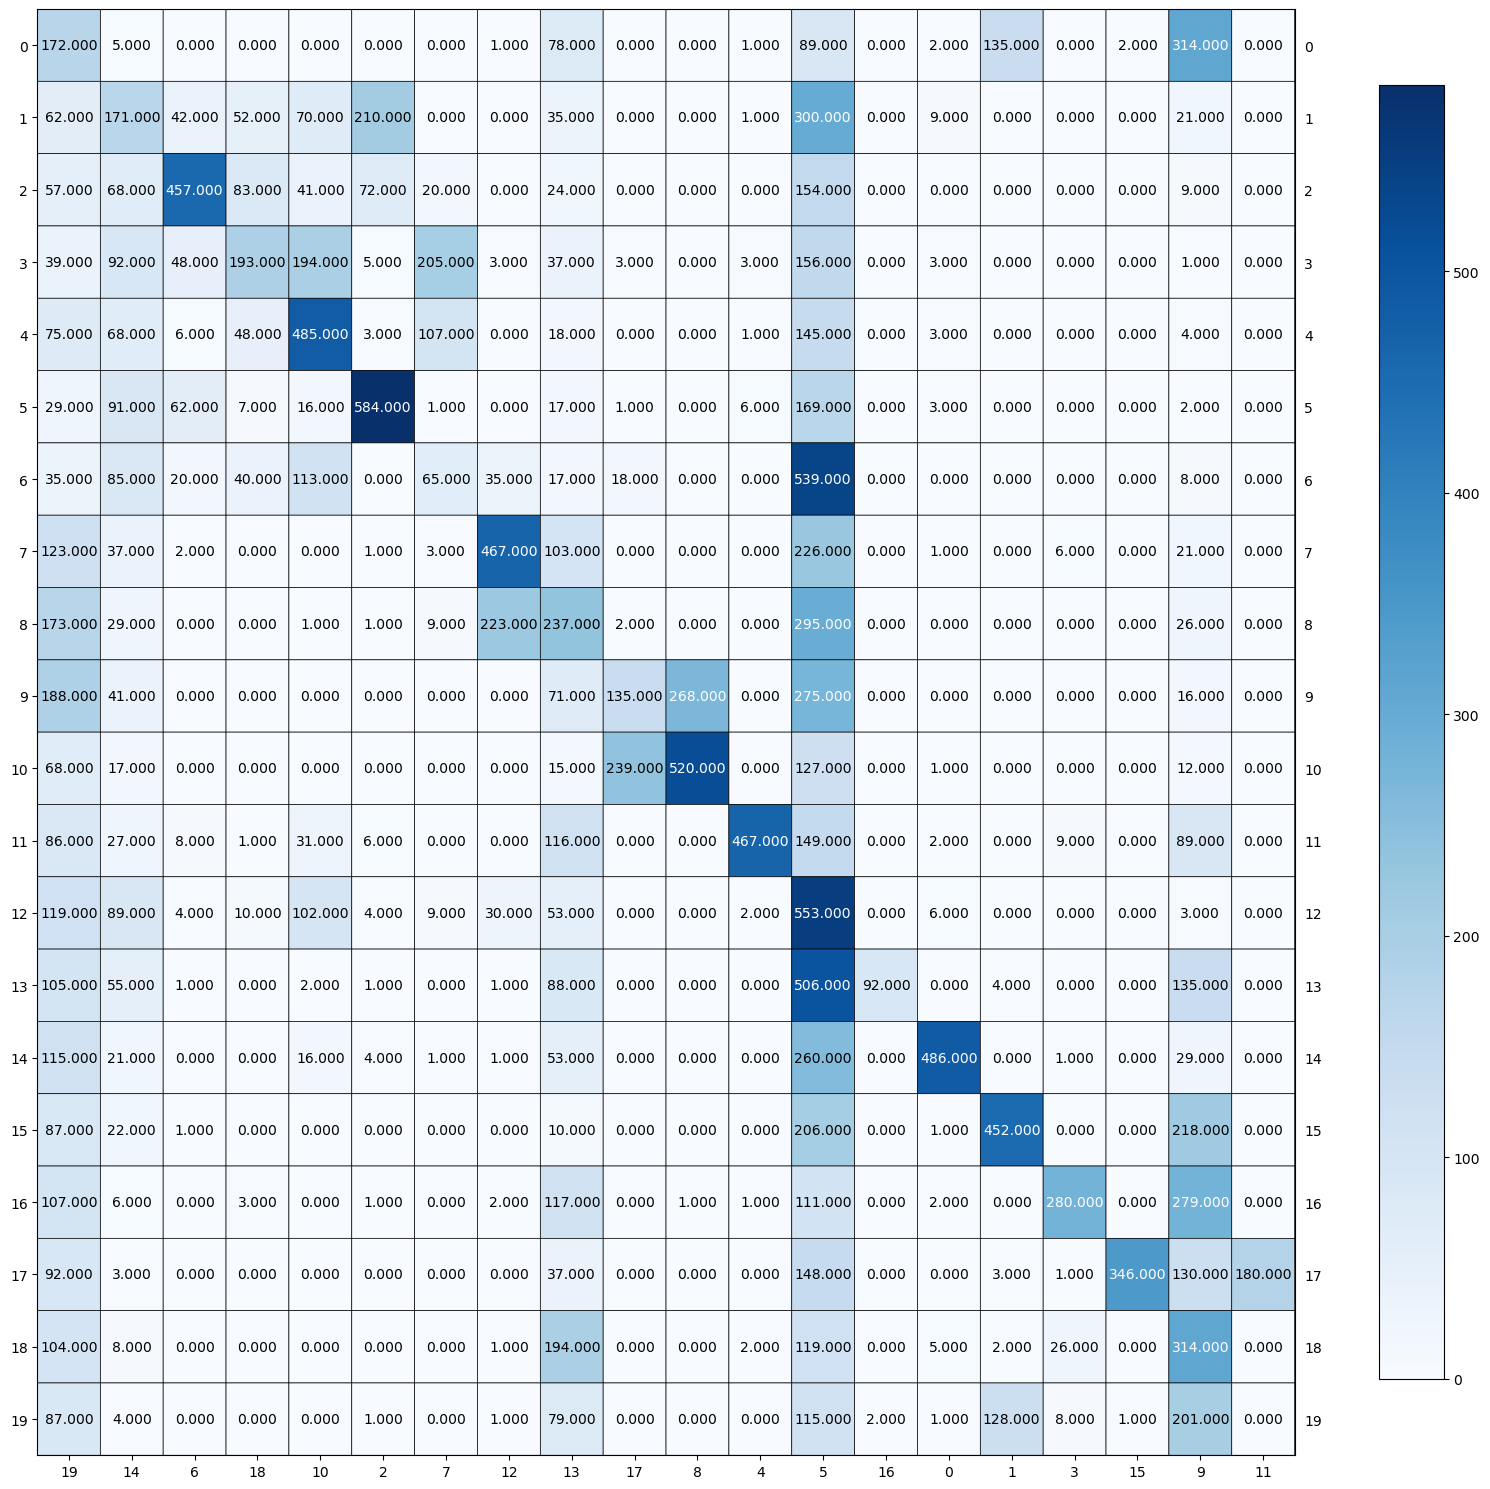

In [129]:
cm = confusion_matrix(data_train_20.target, kmeans.labels_)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,15))